# Proyek Klasifikasi Gambar: [Fruit classification(10 Class)](https://www.kaggle.com/datasets/karimabdulnabi/fruit-classification10-class)
- **Nama:** Muhammad Ferry Fernanda
- **Email:** feefeenan@gmail.com
- **ID Dicoding:** Ferfernanda

## Import Semua Packages/Library yang Digunakan

In [61]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import zipfile
import shutil
from google.colab import drive
import splitfolders
import tensorflowjs

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()
print(tf.config.experimental.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [3]:
%cd "/content/gdrive/Shareddrives/Test/Dicoding/PenerapanMachineLearning"

/content/gdrive/Shareddrives/Test/Dicoding/PenerapanMachineLearning


In [ ]:
%mkdir Dataset

In [ ]:
!pip install kaggle

## Data Preparation

### Data Loading

In [ ]:
!kaggle datasets download -d karimabdulnabi/fruit-classification10-class

Dataset URL: https://www.kaggle.com/datasets/karimabdulnabi/fruit-classification10-class
License(s): CC0-1.0
 58% 17.0M/29.2M [00:00<00:00, 49.3MB/s]
100% 29.2M/29.2M [00:00<00:00, 67.4MB/s]


In [ ]:
%ls

Dataset/  fruit-classification10-class.zip  FruitImageClassification.ipynb  kaggle.json


In [ ]:
zip_ref = zipfile.ZipFile('fruit-classification10-class.zip', 'r')
zip_ref.extractall('Dataset/')
zip_ref.close()

In [ ]:
train_classes = list((os.listdir('Dataset/MY_data/train')))
test_classes = list((os.listdir('Dataset/MY_data/test')))
print('Train:', train_classes)
print('Test:', test_classes)

Train: ['Apple', 'Banana', 'avocado', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'strawberries', 'watermelon']
Test: ['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'stawberries', 'watermelon']


In [ ]:
# Function to normalize names
def normalize_class_name(name):
    return name.lower().replace('stawberries', 'strawberries')

In [ ]:
class_mapping_train = {original: normalized for original, normalized in zip(train_classes, [normalize_class_name(cls) for cls in train_classes])}
class_mapping_test = {original: normalized for original, normalized in zip(test_classes, [normalize_class_name(cls) for cls in test_classes])}

In [ ]:
def rename_data(data_dir, class_names):
  for original_name, normalized_name in class_names.items():
      original_path = os.path.join(data_dir, original_name)
      normalized_path = os.path.join(data_dir, normalized_name)
      if original_path != normalized_path:
          os.rename(original_path, normalized_path)

In [ ]:
rename_data('Dataset/MY_data/train', class_mapping_train)
rename_data('Dataset/MY_data/test', class_mapping_test)

In [32]:
train_classes = sorted(list((os.listdir('Dataset/MY_data/train'))))
test_classes = list((os.listdir('Dataset/MY_data/test')))
print('Train:', train_classes)
print('Test:', test_classes)

Train: ['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'strawberries', 'watermelon']
Test: ['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'watermelon', 'strawberries']


In [28]:
def count_images(data_dir):
  counts = []
  for cls in list((os.listdir(data_dir))):
    train_dir = os.path.join(data_dir, cls)
    counts.append(len(os.listdir(train_dir)))
  return counts

train_counts = count_images('Dataset/MY_data/train')
test_counts = count_images('Dataset/MY_data/test')
print(f"Jumlah gambar dalam folder train: {sum(train_counts)}")
print(f"Jumlah gambar dalam folder test: {sum(test_counts)}")

Jumlah gambar dalam folder train: 2301
Jumlah gambar dalam folder test: 1025


In [ ]:
# Membuat DataFrame untuk visualisasi
data = pd.DataFrame({
    'Class': test_classes,
    'Train': train_counts,
    'Test': test_counts
})

data

,Class,Train,Test
0,apple,230,89
1,avocado,230,105
2,banana,230,106
3,cherry,230,105
4,kiwi,230,105
5,mango,231,105
6,orange,230,97
7,pinenapple,230,105
8,strawberries,230,103
9,watermelon,230,105


### Data Rework

In [29]:
def copy_with_suffix(src_file, dst_file):
    """
    Copy file from src_file to dst_file. If dst_file exists, add a suffix to the filename.
    """
    if not os.path.exists(dst_file):
        shutil.copyfile(src_file, dst_file)
    else:
        base, extension = os.path.splitext(dst_file)
        i = 1
        new_dst_file = f"{base}_{i}{extension}"
        while os.path.exists(new_dst_file):
            i += 1
            new_dst_file = f"{base}_{i}{extension}"
        shutil.copyfile(src_file, new_dst_file)

In [30]:
combined_dir = 'Dataset/rework'
os.makedirs(combined_dir, exist_ok=True)

In [ ]:
for cls in train_classes:
    # Membuat folder kelas di folder gabungan
    class_combined_dir = os.path.join(combined_dir, cls)
    os.makedirs(class_combined_dir, exist_ok=True)

    # Copy file dari folder train
    class_train_dir = os.path.join('Dataset/MY_data/train', cls)
    for file_name in os.listdir(class_train_dir):
        src_file = os.path.join(class_train_dir, file_name)
        dst_file = os.path.join(class_combined_dir, file_name)
        copy_with_suffix(src_file, dst_file)
    print('class', cls, 'pada train berhasil')

for cls in test_classes:
    # Membuat folder kelas di folder gabungan
    class_combined_dir = os.path.join(combined_dir, cls)
    os.makedirs(class_combined_dir, exist_ok=True)

    # Copy file dari folder train
    class_test_dir = os.path.join('Dataset/MY_data/test', cls)
    for file_name in os.listdir(class_test_dir):
        src_file = os.path.join(class_test_dir, file_name)
        dst_file = os.path.join(class_combined_dir, file_name)
        copy_with_suffix(src_file, dst_file)
    print('class', cls, 'pada test berhasil')

class apple pada train berhasil
class avocado pada train berhasil
class banana pada train berhasil
class cherry pada train berhasil
class kiwi pada train berhasil
class mango pada train berhasil
class orange pada train berhasil
class pinenapple pada train berhasil
class strawberries pada train berhasil
class watermelon pada train berhasil
class apple pada test berhasil
class avocado pada test berhasil
class banana pada test berhasil
class cherry pada test berhasil
class kiwi pada test berhasil
class mango pada test berhasil
class orange pada test berhasil
class pinenapple pada test berhasil
class strawberries pada test berhasil
class watermelon pada test berhasil


In [33]:
combined_counts = count_images(combined_dir)
print(test_classes, combined_counts)
print(f"Jumlah gambar dalam folder combined: {sum(combined_counts)}")

['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'watermelon', 'strawberries'] [319, 335, 336, 335, 335, 336, 327, 335, 333, 335]
Jumlah gambar dalam folder combined: 3326


In [ ]:
# Membuat DataFrame untuk visualisasi
data_rework = pd.DataFrame({
    'Class': test_classes,
    'Count': combined_counts,
})

data_rework

,Class,Count
0,apple,319
1,avocado,335
2,banana,336
3,cherry,335
4,kiwi,335
5,mango,336
6,orange,327
7,pinenapple,335
8,strawberries,333
9,watermelon,335


In [34]:
!pip install split-folders
import splitfolders

In [35]:
# Path ke folder dataset gabungan
split_base_dir = 'Dataset/FruitImage'
splitfolders.ratio(combined_dir, output=split_base_dir, seed=1337, ratio=(.8, .2))

Copying files: 3326 files [01:48, 30.63 files/s]


In [36]:
train = count_images(os.path.join(split_base_dir, 'train'))
val = count_images(os.path.join(split_base_dir, 'val'))
print(f"Jumlah gambar dalam folder train: {sum(train)}")
print(f"Jumlah gambar dalam folder val: {sum(val)}")

Jumlah gambar dalam folder train: 2658
Jumlah gambar dalam folder val: 668


### EDA

In [37]:
train_dir = 'Dataset/FruitImage/train'
test_dir = 'Dataset/FruitImage/val'
classes = sorted(list((os.listdir(train_dir))))

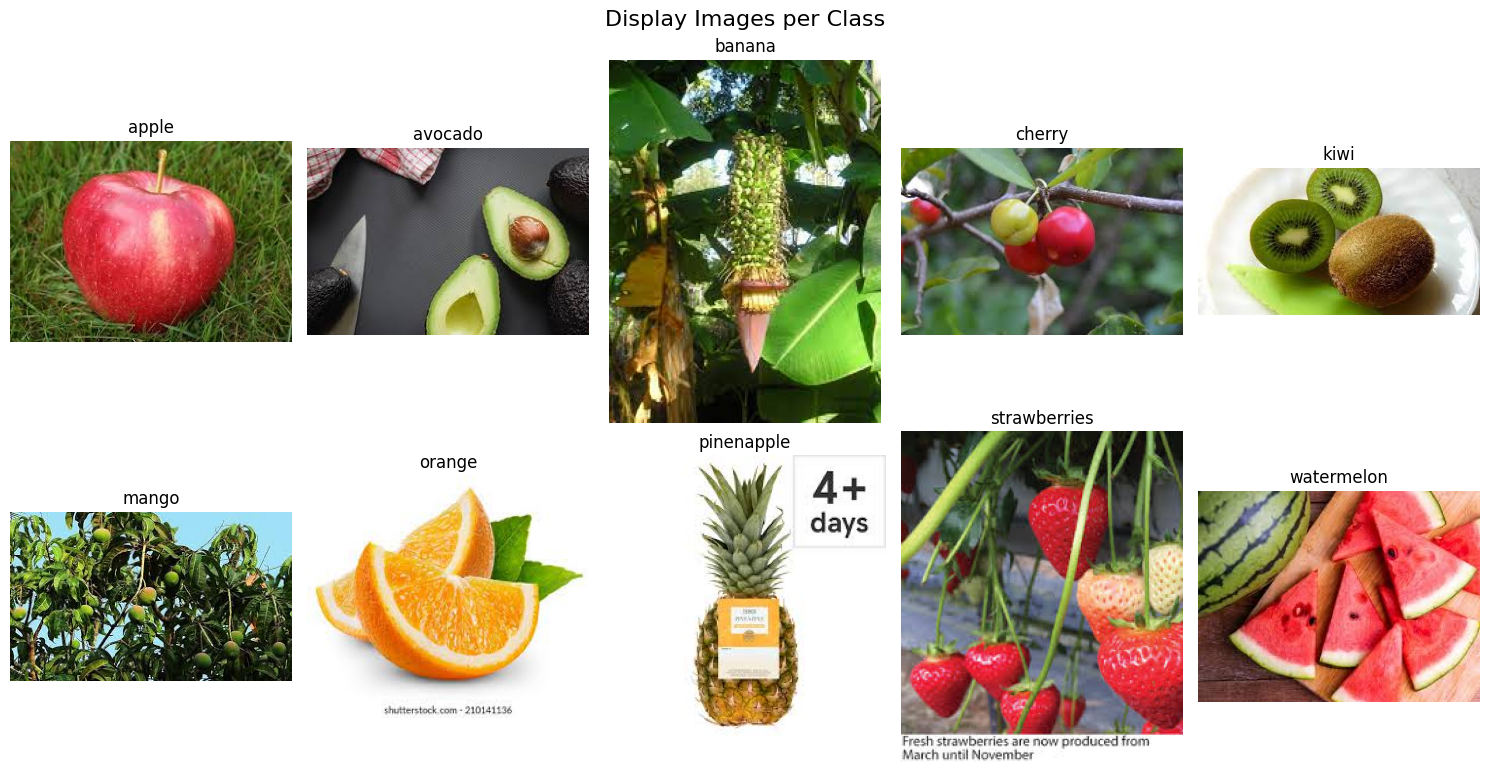

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.flatten()

for ax, cls in zip(axes, train_classes):
    class_dir = train_dir + '/' + cls
    img_path = os.path.join(class_dir, os.listdir(class_dir)[0])
    img = plt.imread(img_path)
    ax.imshow(img)
    ax.set_title(cls)
    ax.axis('off')

fig.suptitle('Display Images per Class', fontsize=16)
plt.tight_layout()
plt.show()

In [41]:
# Menghitung jumlah gambar di setiap kelas setelah augmentasi
def plot_class_distribution(dir, ttl, cls = classes):
    class_counts = []
    for cls in classes:
        class_dir = os.path.join(dir, cls)
        class_counts.append(len(os.listdir(class_dir)))

    # Membuat DataFrame untuk visualisasi
    df = pd.DataFrame({
        'Class': classes,
        'Count': class_counts
    })

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(df['Class'], df['Count'], color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title(ttl)
    plt.show()

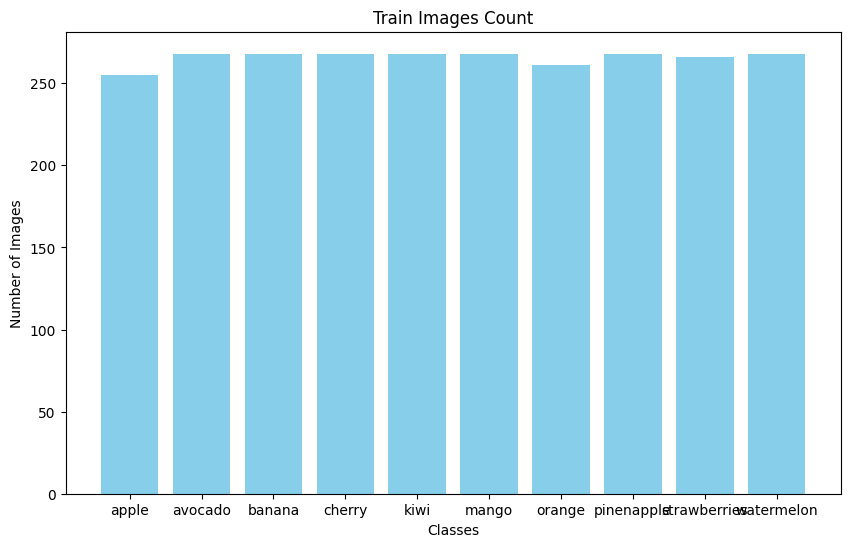

In [42]:
plot_class_distribution(train_dir, 'Train Images Count')

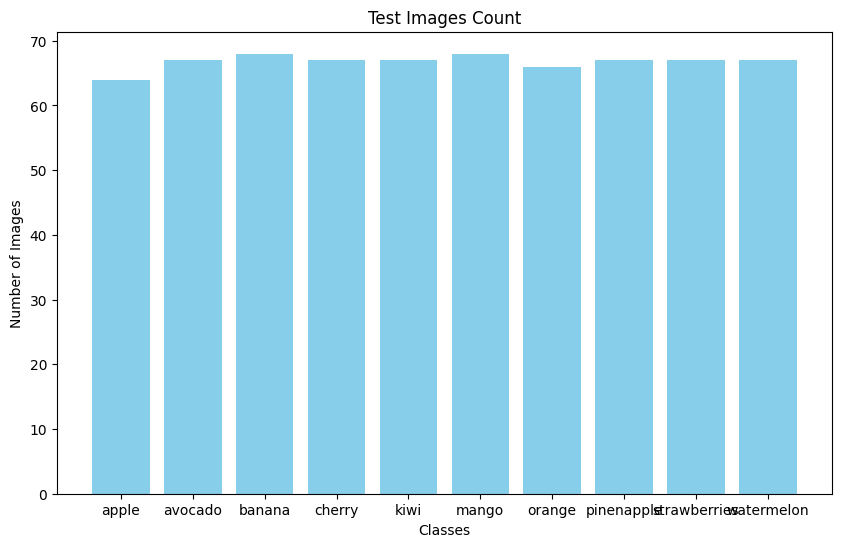

In [ ]:
plot_class_distribution(test_dir, 'Test Images Count')

### Data Preprocessing

In [44]:
# Image size and batch size
img_height, img_width = 128, 128
batch_size = 32

# Data augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

#### Split Dataset

In [74]:
# Load the training data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Load the validation data
validation_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle = False
)

# Load the test data
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    shuffle = False
)

Found 2131 images belonging to 10 classes.
Found 527 images belonging to 10 classes.
Found 668 images belonging to 10 classes.


## Modelling

In [83]:
from tensorflow.keras.applications import MobileNetV2

# Load the pre-trained EfficientNetB4 model without the top classification layer
MobileNetV2_base = MobileNetV2(weights='imagenet',
                               include_top=False,
                               input_shape=(128, 128, 3),
                               pooling='avg')

# Freeze the pre-trained base model layers
MobileNetV2_base.trainable = False

In [84]:
# Build the model
model = Sequential(name = 'FruitClassification_MobileNetV2')

# Add the pre-trained Xception base
model.add(MobileNetV2_base)
model.add(BatchNormalization())
# model.add(Dropout(0.5))

# Dropout Layer
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Add the output layer
model.add(Dense(10, activation='softmax'))

In [85]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [86]:
model.summary()

Model: "FruitClassification_MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 batch_normalization_10 (Ba  (None, 1280)              5120      
 tchNormalization)                                               
                                                                 
 dense_24 (Dense)            (None, 256)               327936    
                                                                 
 dense_25 (Dense)            (None, 128)               32896     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None,

## Evaluasi dan Visualisasi

In [82]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.95):
            print("\nAccuracy > 96%, stop training")
            self.model.stop_training = True

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr= 1e-6
)

# early_stopping = EarlyStopping(
#     monitor='val_accuracy',
#     patience=15,
#     restore_best_weights=True
# )

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

callbacks = [myCallback(),
             reduce_lr,
            #  early_stopping,
             checkpoint]

In [87]:
# Train the model
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=100,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/100
67/67 [==============================] - 27s 340ms/step - loss: 1.2988 - accuracy: 0.5866 - val_loss: 0.5998 - val_accuracy: 0.8008 - lr: 0.0010
Epoch 2/100
67/67 [==============================] - 23s 339ms/step - loss: 0.6612 - accuracy: 0.7818 - val_loss: 0.4729 - val_accuracy: 0.8501 - lr: 0.0010
Epoch 3/100
67/67 [==============================] - 21s 321ms/step - loss: 0.5194 - accuracy: 0.8306 - val_loss: 0.3815 - val_accuracy: 0.8710 - lr: 0.0010
Epoch 4/100
67/67 [==============================] - 21s 314ms/step - loss: 0.4139 - accuracy: 0.8686 - val_loss: 0.3963 - val_accuracy: 0.8805 - lr: 0.0010
Epoch 5/100
67/67 [==============================] - 21s 321ms/step - loss: 0.3650 - accuracy: 0.8756 - val_loss: 0.4011 - val_accuracy: 0.8767 - lr: 0.0010
Epoch 6/100
67/67 [==============================] - 20s 304ms/step - loss: 0.3422 - accuracy: 0.8756 - val_loss: 0.3751 - val_accuracy: 0.8710 - lr: 0.0010
Epoch 7/100
67/67 [==============================] - 22s 3

In [88]:
test_loss, test_acc = model.evaluate(test_data)

print("Test Loss: {:.5f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_acc * 100))

21/21 [==============================] - 4s 183ms/step - loss: 0.4424 - accuracy: 0.8937
Test Loss: 0.44240
Test Accuracy: 89.37%


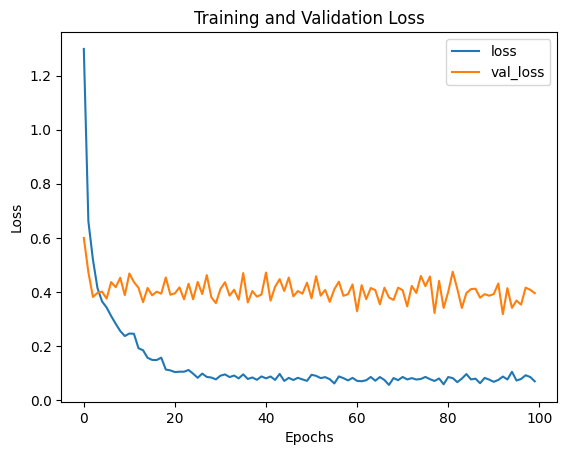

In [89]:
# Plotting training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

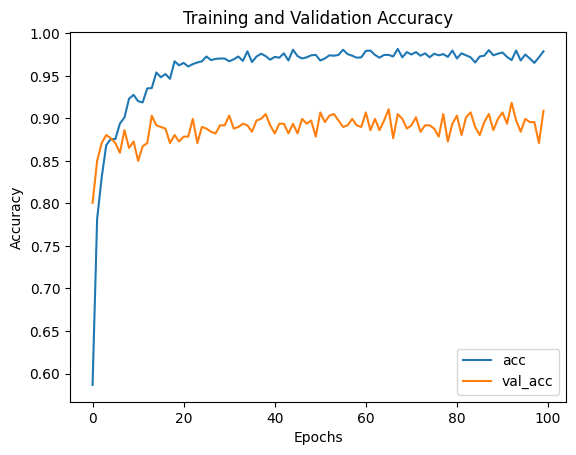

In [90]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

## Konversi Model

In [91]:
!pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 32.7 MB/s eta 0:

In [92]:
# Save model in SavedModel format
model.save('FruitClassification_MobileNetV2.keras')

In [93]:
from tensorflow.keras.models import load_model

x = load_model('FruitClassification_MobileNetV2.h5')
x.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 batch_normalization_2 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               327936    
                                                                 
 dense_9 (Dense)             (None, 64)                16448     
                                                                 
 dense_10 (Dense)            (None, 10)               

In [94]:
x.evaluate(test_data)

21/21 [==============================] - 4s 120ms/step - loss: 0.3828 - accuracy: 0.9012


[0.3827587962150574, 0.901197612285614]

In [95]:
# Save model in TF-Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('FruitClassification_MobileNetV2.tflite', 'wb') as f:
    f.write(tflite_model)

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7b9ab71e9bd0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7b9ab71e9bd0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [96]:
# Membuat label.txt
with open('label.txt', 'w') as f:
    for label in classes:
        f.write(f"{label}\n")

In [97]:
# Save model in TFJS format
!tensorflowjs_converter --input_format keras FruitClassification_MobileNetV2.h5 ./tfjs_model

2024-07-27 15:43:30.976994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 15:43:31.001449: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 15:43:31.001511: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-27 15:43:32.235386: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
tf.saved_model.save(model, 'Model/')

## Inference (Optional)